In [2]:
!pip install scikit-learn

In [95]:
#library untuk pengolahan data
import pandas as pd 
import numpy as np

#library untuk visualisasi data
import matplotlib.pyplot as plt 
import seaborn as sns

#library untuk machine learning model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot


In [96]:
#UPLOAD DATA

In [97]:
#upload data dan define nya sebagai df_
df_transaction = pd.read_csv ('Transaction.csv', delimiter =';')
df_product = pd.read_csv ('Product.csv', delimiter =';')
df_store = pd.read_csv ('Store.csv', delimiter =';')
df_customer = pd.read_csv ('Customer.csv', delimiter =';')

In [98]:
#untuk mengetahui bentuk dataframe (basis, kolom)
df_transaction.shape, df_store.shape, df_store.shape, df_customer.shape

((5020, 8), (14, 6), (14, 6), (447, 5))

In [99]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [100]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [101]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [102]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [103]:
#mendapatkan informasi data
df_transaction.info()
df_store.info()
df_product.info()
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null  

In [104]:
#data cleansing df transaction, kolom Date di ubah menjadi tipe data time menggunakan pd.to_datetime() 
df_transaction ['Date'] = pd.to_datetime(df_transaction ['Date'])

C:\Users\victus\AppData\Local\Temp\ipykernel_21888\2736268995.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_transaction ['Date'] = pd.to_datetime(df_transaction ['Date'])


In [105]:
#data cleansing df customer
df_customer ['Income'] = df_customer ['Income'].replace('[,]', '.', regex = True).astype('float')

In [106]:
#data cleansing df store
df_store ['Latitude'] = df_store ['Latitude'].replace('[,]', '.', regex = True).astype('float')
df_store ['Longitude'] = df_store ['Longitude'].replace('[,]', '.', regex = True).astype('float')


In [107]:
#merge data transactiom dan customer didasarkan pada kolom customer id
df_merge = pd.merge (df_transaction, df_customer, on = ['CustomerID'])
#merge data hasil merge dengan product, menghilangkan kolom price biar tidak double
df_merge = pd.merge (df_merge, df_product.drop (columns=['Price']), on =['ProductID'])
#merge data hasil merge 2 dengan store didasarkan pada kolom store id
df_merge = pd.merge (df_merge, df_store, on = ['StoreID'])


In [108]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [109]:
#ambil data yang penting
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty':'sum'
}).reset_index()



In [110]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


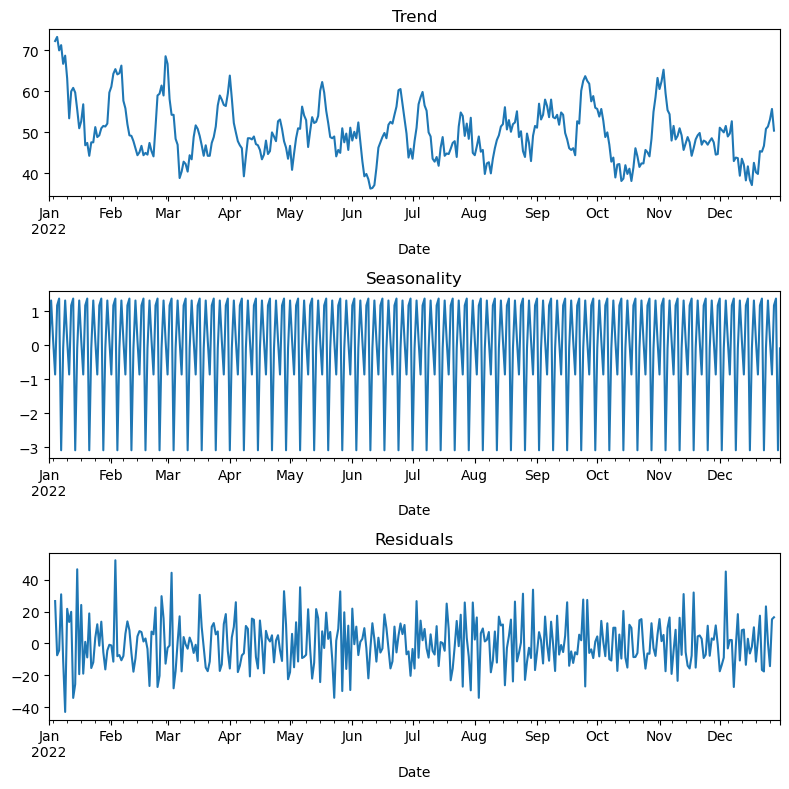

In [111]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(8,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title ('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title ('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title ('Residuals')

plt.tight_layout()

In [112]:
# Split data
cut_off = round(df_regresi.shape[0] * 0.9)
df_train = df_regresi.iloc[:cut_off]
df_test = df_regresi.iloc[cut_off:]



# Cek bentuk (shape) dari data training dan data testing
print

(df_train.shape, df_test.shape)


((328, 2), (37, 2))

In [113]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
323,2022-11-20,55
324,2022-11-21,55
325,2022-11-22,49
326,2022-11-23,40


In [114]:
df_test

,Date,Qty
328,2022-11-25,55
329,2022-11-26,40
330,2022-11-27,53
331,2022-11-28,50
332,2022-11-29,55
333,2022-11-30,45
334,2022-12-01,35
335,2022-12-02,34
336,2022-12-03,41
337,2022-12-04,98


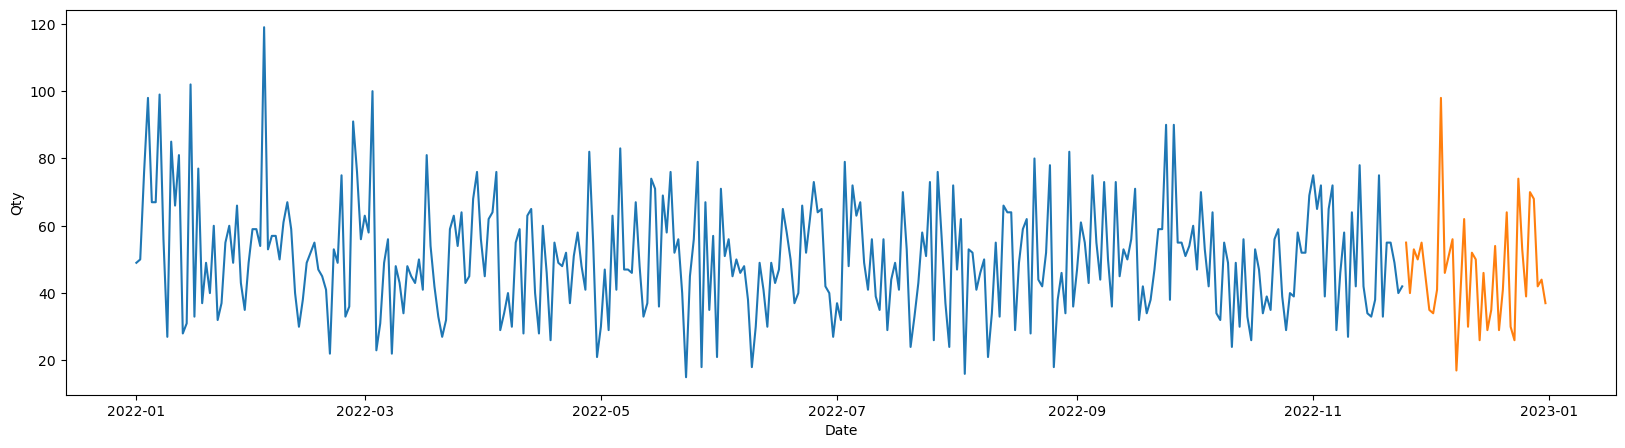

In [115]:
plt.figure(figsize=(20,5))
sns.lineplot(data = df_train, x=df_train['Date'], y=df_train['Qty']);
sns.lineplot(data = df_test, x=df_test['Date'], y=df_test['Qty']);

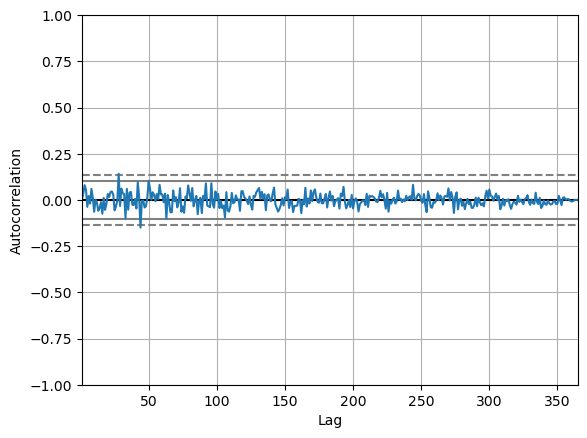

In [116]:
#identifikasi pola korelasi data
autocorrelation_plot(df_regresi['Qty']);

In [119]:
def rmse(y_actual, y_pred):
    
    #Function to calculate Root Mean Squared Error (RMSE)
    
    rmse_value = mean_squared_error(y_actual, y_pred, squared=False)
    print(f'RMSE value: {rmse_value}')

def eval(y_actual, y_pred):
   
    #Function to evaluate machine learning modeling
   
    rmse(y_actual, y_pred)
    mae_value = mean_absolute_error(y_actual, y_pred)
    print(f'MAE value: {mae_value}')

C:\Users\victus\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\victus\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\victus\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE value: 15.98935538707141
MAE value: 12.440123194497154


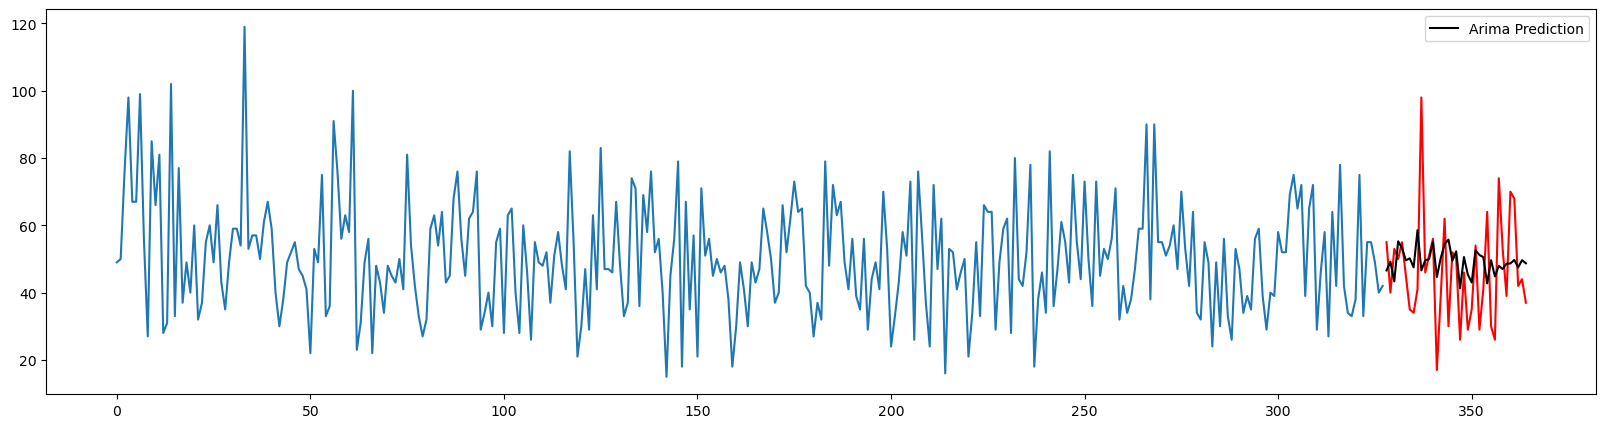

In [118]:
df_train.set_index ('Date')
df_test.set_index ('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order=(40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))
                                     
y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start =y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label= 'Arima Prediction')
plt.legend()
                                     